In [36]:
# Bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Carregando a base de dados

In [6]:
df = pd.read_excel('default of credit card clients.xlsx')
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


Ajustando o cabeçalho

In [7]:
df.columns = df.iloc[0]
df = df.drop(index=0)
df = df.reset_index(drop=True)

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Verificar estatísticas básicas

In [8]:
print(df.describe())

0          ID  LIMIT_BAL    SEX  EDUCATION  MARRIAGE    AGE  PAY_0  PAY_2  \
count   30000      30000  30000      30000     30000  30000  30000  30000   
unique  30000         81      2          7         4     56     11     11   
top     29984      50000      2          2         2     29      0      0   
freq        1       3365  18112      14030     15964   1605  14737  15730   

0       PAY_3  PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
count   30000  30000  ...      30000      30000      30000     30000   
unique     11     11  ...      21548      21010      20604      7943   
top         0      0  ...          0          0          0         0   
freq    15764  16455  ...       3195       3506       4020      5249   

0       PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
count      30000     30000     30000     30000     30000   
unique      7899      7518      6937      6897      6939   
top            0         0         0         0         0   
freq        5

Antes de prosseguir com a análise, é importante verificar se existem valores ausentes e tipos das colunas e tratar os dados

In [9]:
df.isnull().sum()
print(df.dtypes)

# Converter todas as colunas possíveis para valores numéricos
df = df.apply(pd.to_numeric, errors='coerce')

# Verificar colunas com NaN após conversão
print(df.isna().sum())

# (Exemplo) Preencher NaNs com a mediana de cada coluna
df.fillna(df.median(), inplace=True)


0
ID                            object
LIMIT_BAL                     object
SEX                           object
EDUCATION                     object
MARRIAGE                      object
AGE                           object
PAY_0                         object
PAY_2                         object
PAY_3                         object
PAY_4                         object
PAY_5                         object
PAY_6                         object
BILL_AMT1                     object
BILL_AMT2                     object
BILL_AMT3                     object
BILL_AMT4                     object
BILL_AMT5                     object
BILL_AMT6                     object
PAY_AMT1                      object
PAY_AMT2                      object
PAY_AMT3                      object
PAY_AMT4                      object
PAY_AMT5                      object
PAY_AMT6                      object
default payment next month    object
dtype: object
0
ID                            0
LIMIT_BAL                

# 1. Análise Exploratória de Dados - EDA

Histogramas com Densidade das variáveis

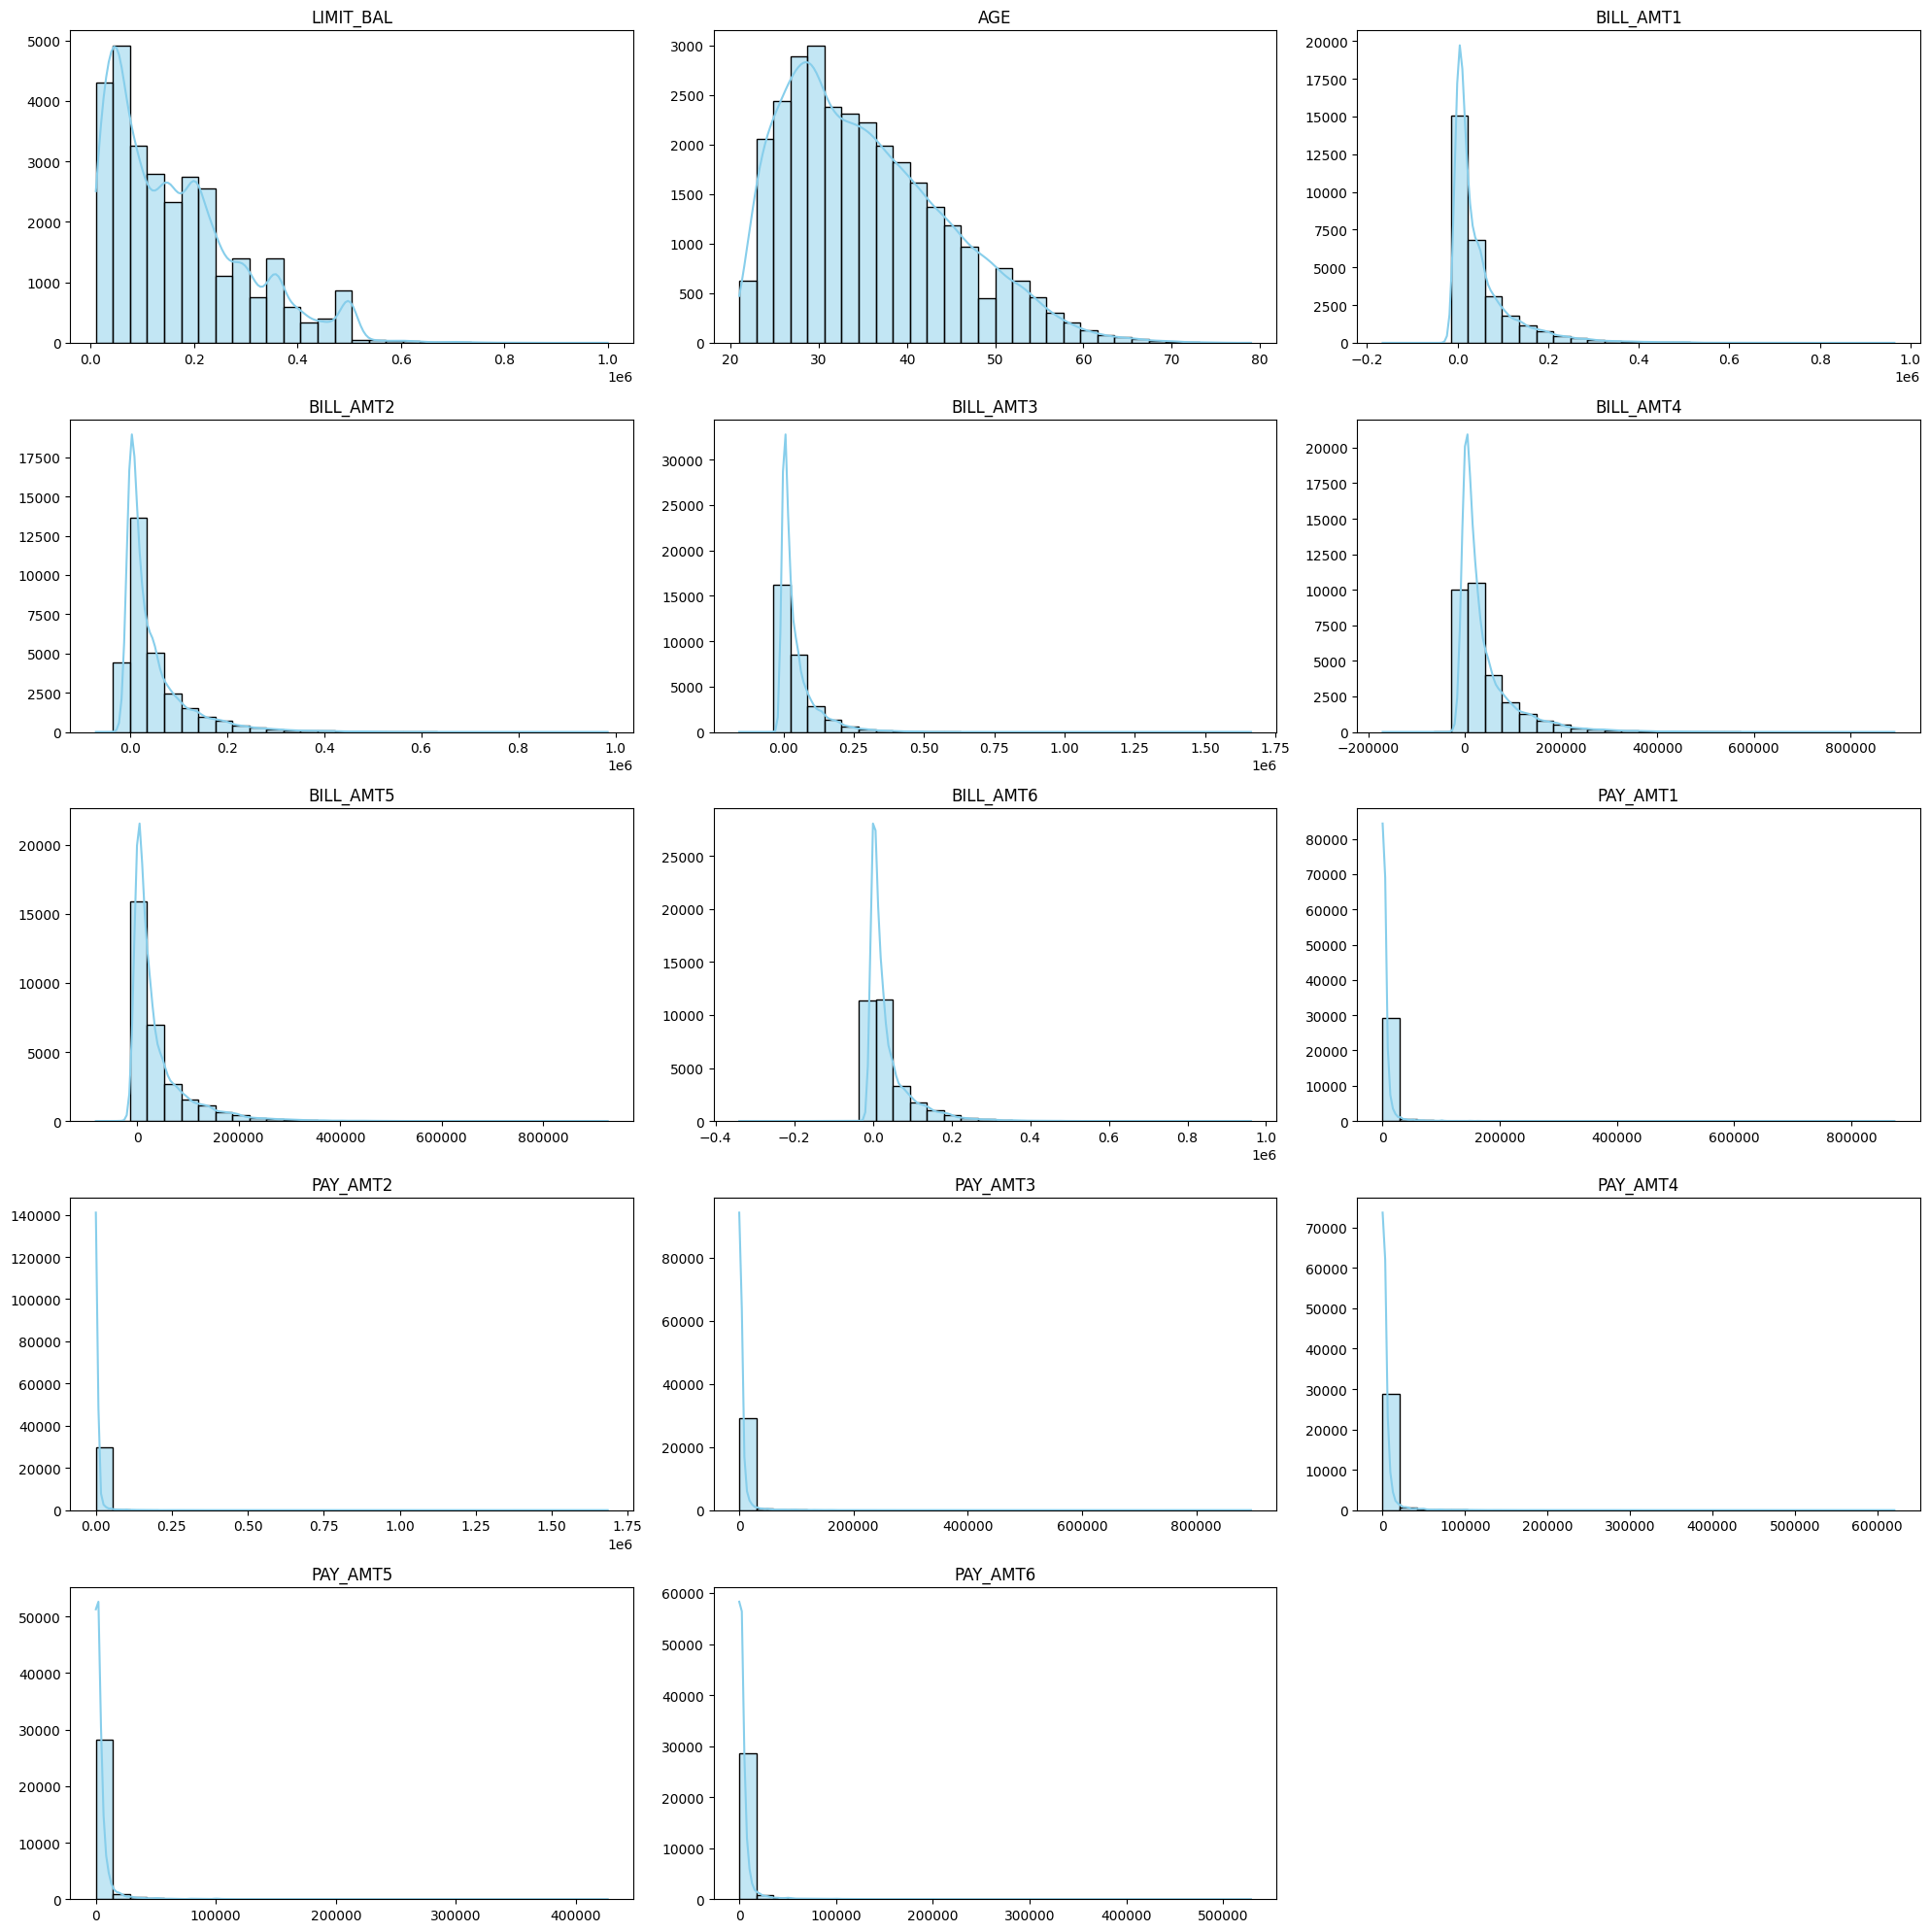

In [10]:
# Lista com os nomes das colunas numéricas (exemplo, você pode ajustar conforme sua base)
colunas_numericas = [
    'LIMIT_BAL', 'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

# Plotando histogramas com densidade para essas colunas
plt.figure(figsize=(20, 20))
for i, coluna in enumerate(colunas_numericas):
    plt.subplot(5, 3, i+1)  # Ajuste o grid conforme o número de colunas
    sns.histplot(df[coluna], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(coluna)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

Boxplot por variável

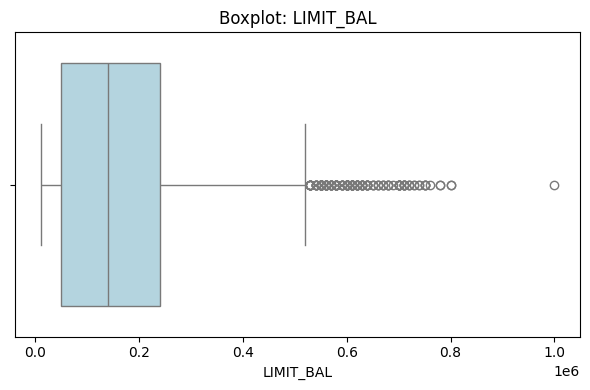

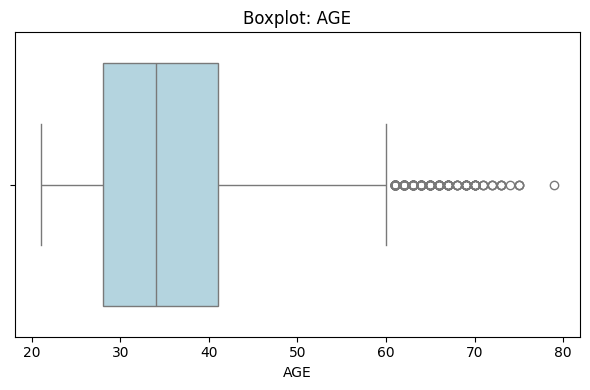

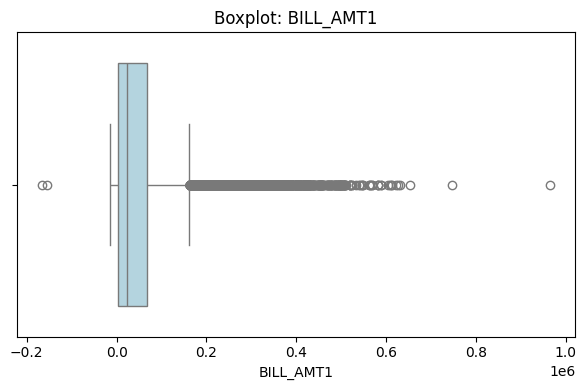

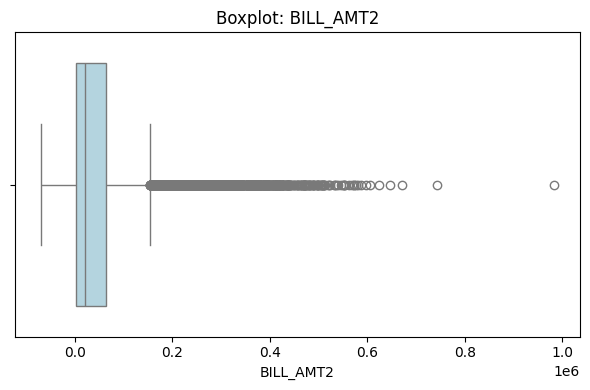

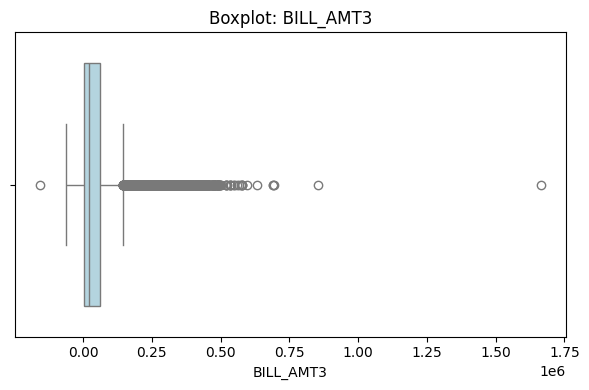

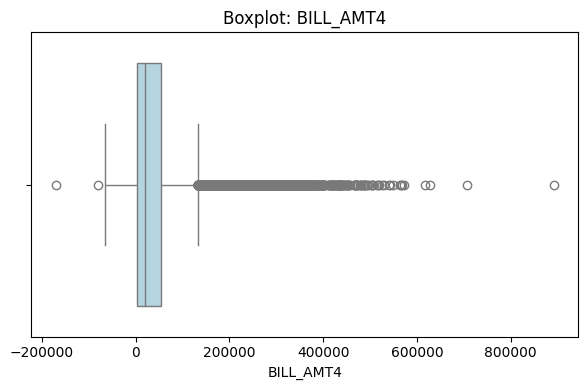

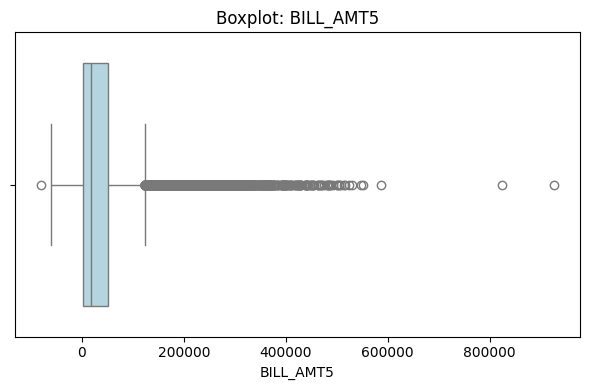

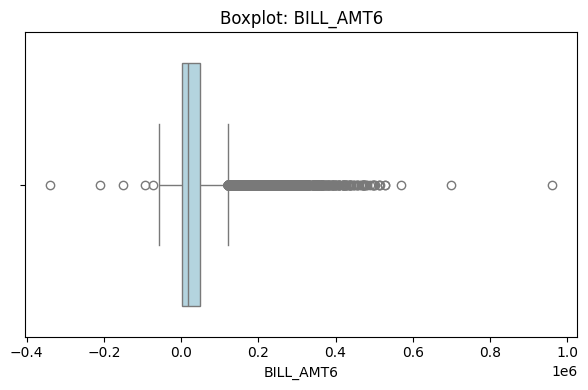

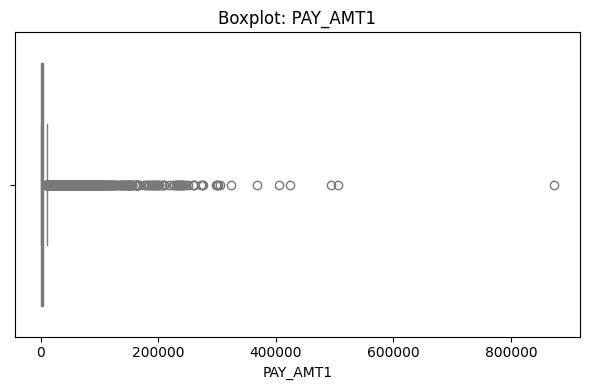

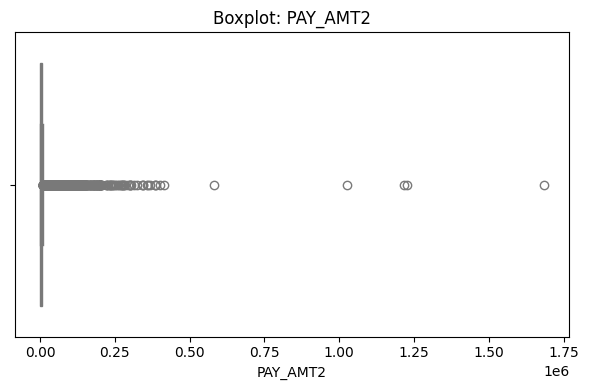

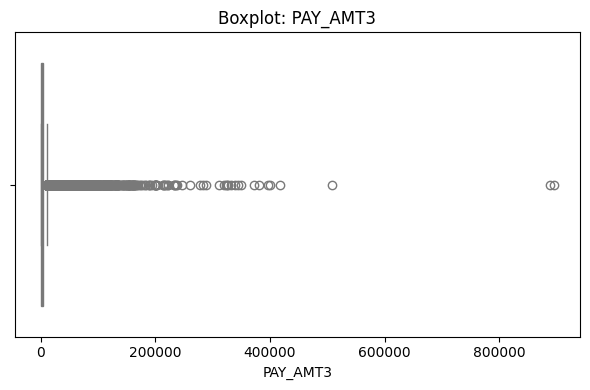

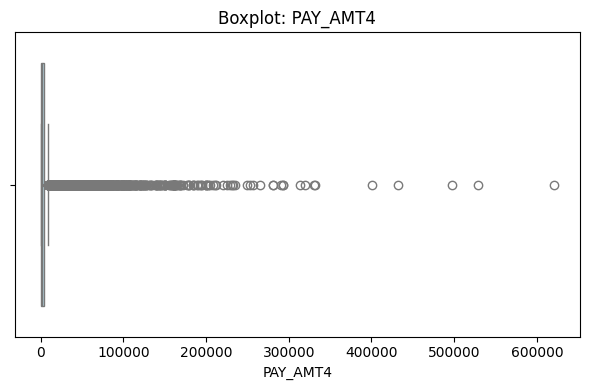

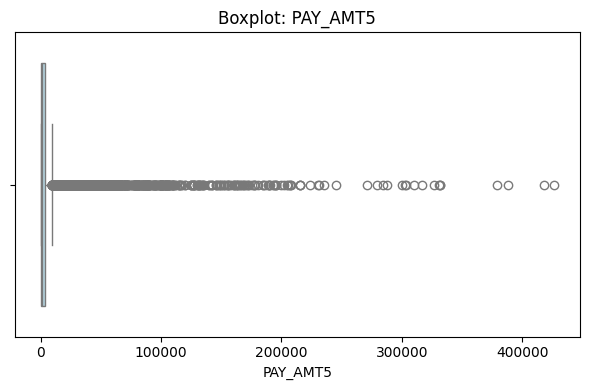

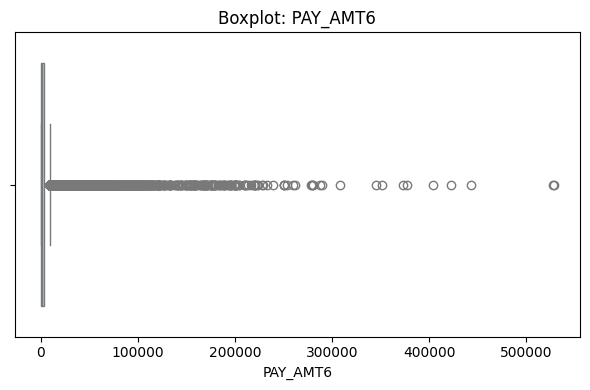

In [11]:
for coluna in colunas_numericas:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[coluna], color='lightblue')
    plt.title(f'Boxplot: {coluna}')
    plt.xlabel(coluna)
    plt.tight_layout()
    plt.show()

Estatísticas descritivas

In [12]:
for coluna in colunas_numericas:
    dados = df[coluna].dropna()
    print(f'📌 {coluna}')
    print(f'  Média:     {dados.mean():.2f}')
    print(f'  Mediana:   {dados.median():.2f}')
    print(f'  Desvio:    {dados.std():.2f}')
    print(f'  Assimetria (skew):   {skew(dados):.2f}')
    print(f'  Curtose:   {kurtosis(dados):.2f}')
    print('-' * 40)


📌 LIMIT_BAL
  Média:     167484.32
  Mediana:   140000.00
  Desvio:    129747.66
  Assimetria (skew):   0.99
  Curtose:   0.54
----------------------------------------
📌 AGE
  Média:     35.49
  Mediana:   34.00
  Desvio:    9.22
  Assimetria (skew):   0.73
  Curtose:   0.04
----------------------------------------
📌 BILL_AMT1
  Média:     51223.33
  Mediana:   22381.50
  Desvio:    73635.86
  Assimetria (skew):   2.66
  Curtose:   9.80
----------------------------------------
📌 BILL_AMT2
  Média:     49179.08
  Mediana:   21200.00
  Desvio:    71173.77
  Assimetria (skew):   2.71
  Curtose:   10.30
----------------------------------------
📌 BILL_AMT3
  Média:     47013.15
  Mediana:   20088.50
  Desvio:    69349.39
  Assimetria (skew):   3.09
  Curtose:   19.78
----------------------------------------
📌 BILL_AMT4
  Média:     43262.95
  Mediana:   19052.00
  Desvio:    64332.86
  Assimetria (skew):   2.82
  Curtose:   11.31
----------------------------------------
📌 BILL_AMT5
  Média:

Gráficos QQ

Verificamos visualmente se a distribuição da variável se aproxima de uma normal.

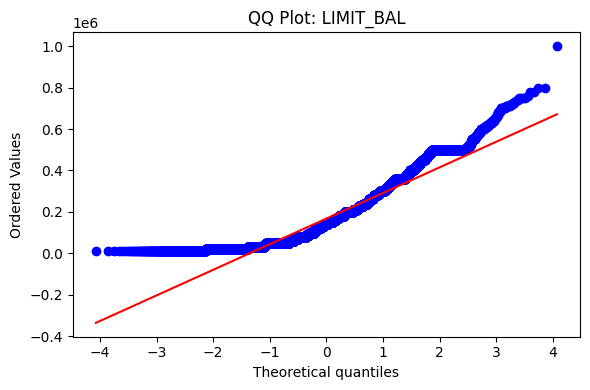

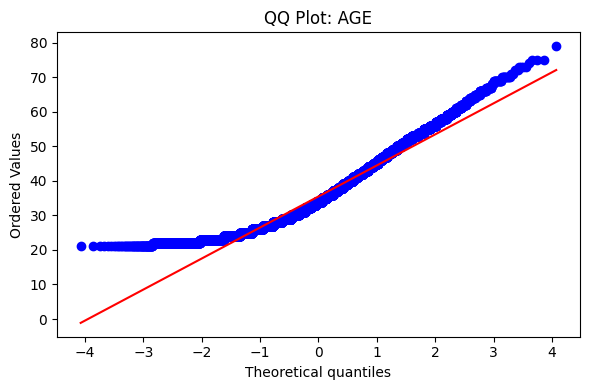

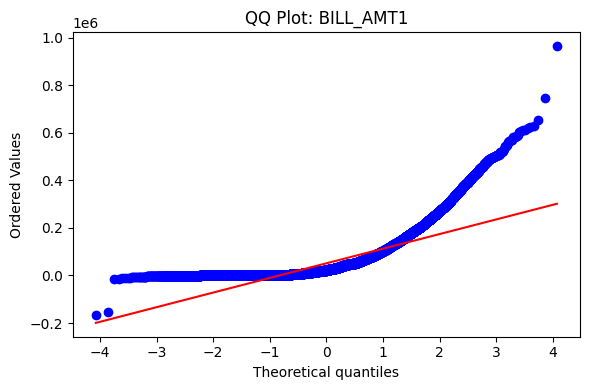

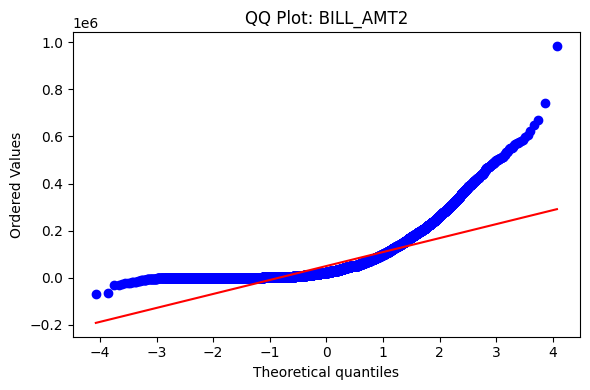

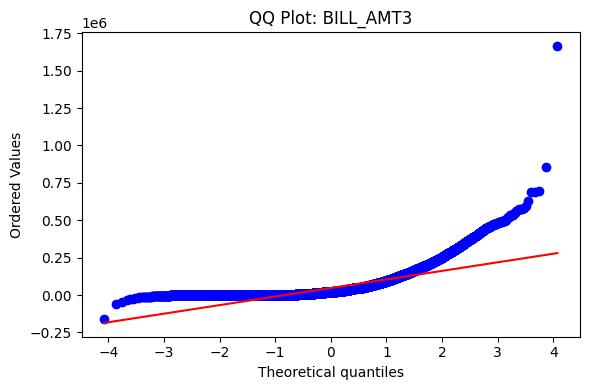

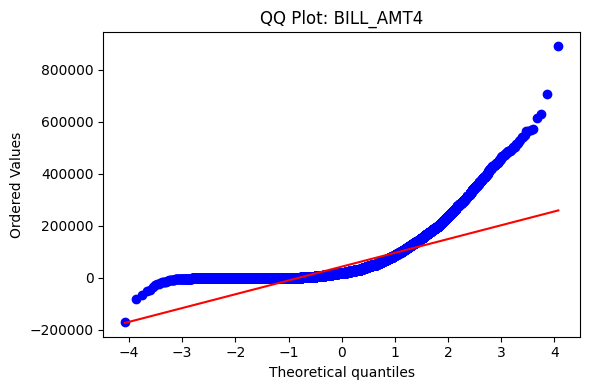

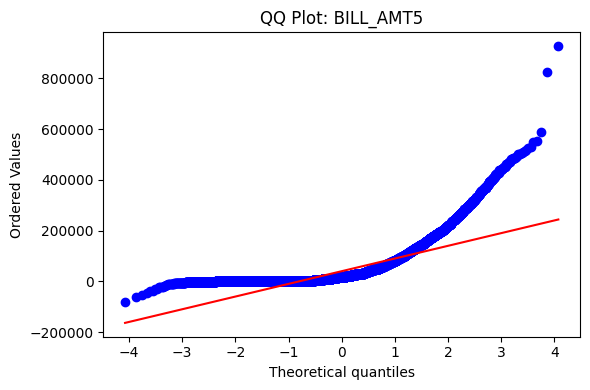

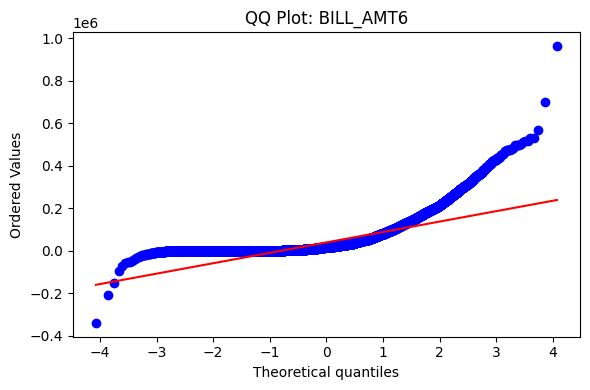

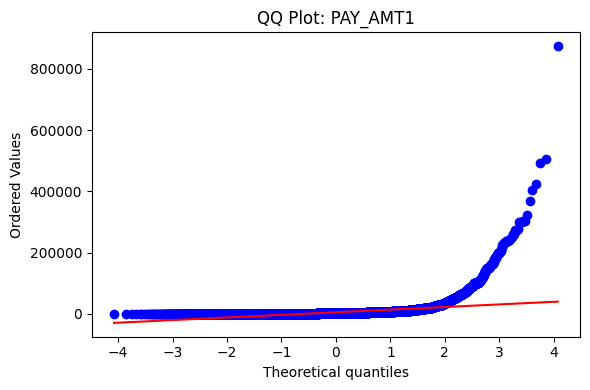

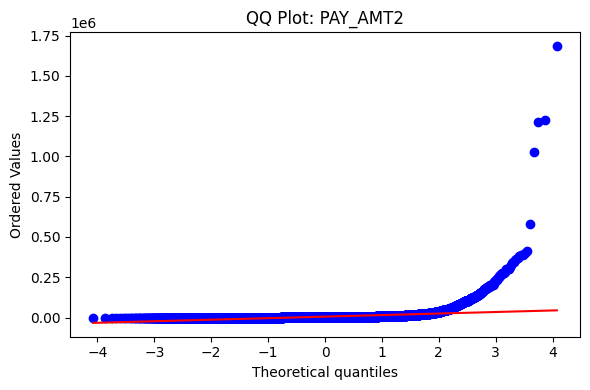

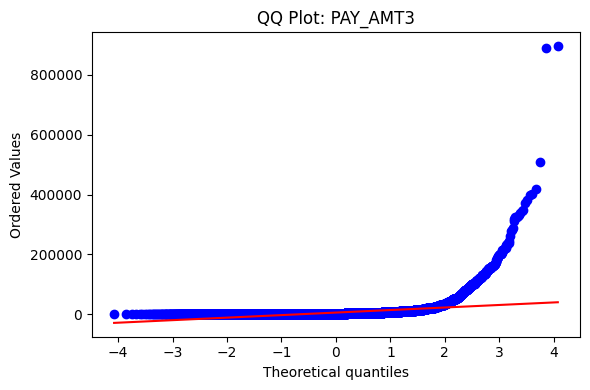

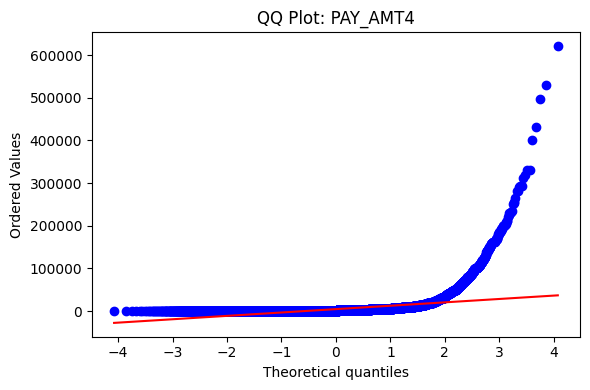

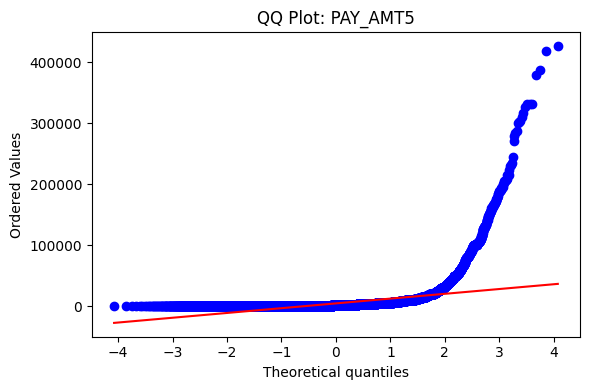

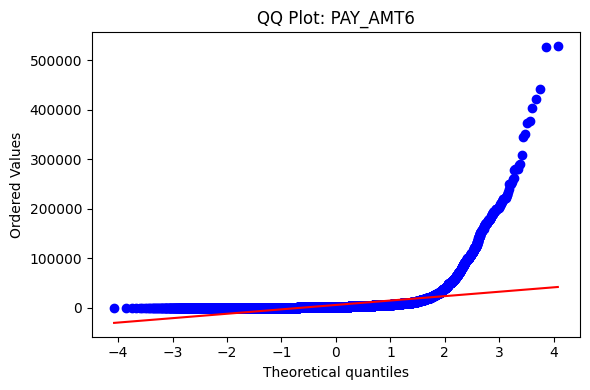

In [13]:
import scipy.stats as stats

for coluna in colunas_numericas:
    plt.figure(figsize=(6, 4))
    stats.probplot(df[coluna].dropna(), dist="norm", plot=plt)
    plt.title(f'QQ Plot: {coluna}')
    plt.tight_layout()
    plt.show()


Correlação entre Variáveis

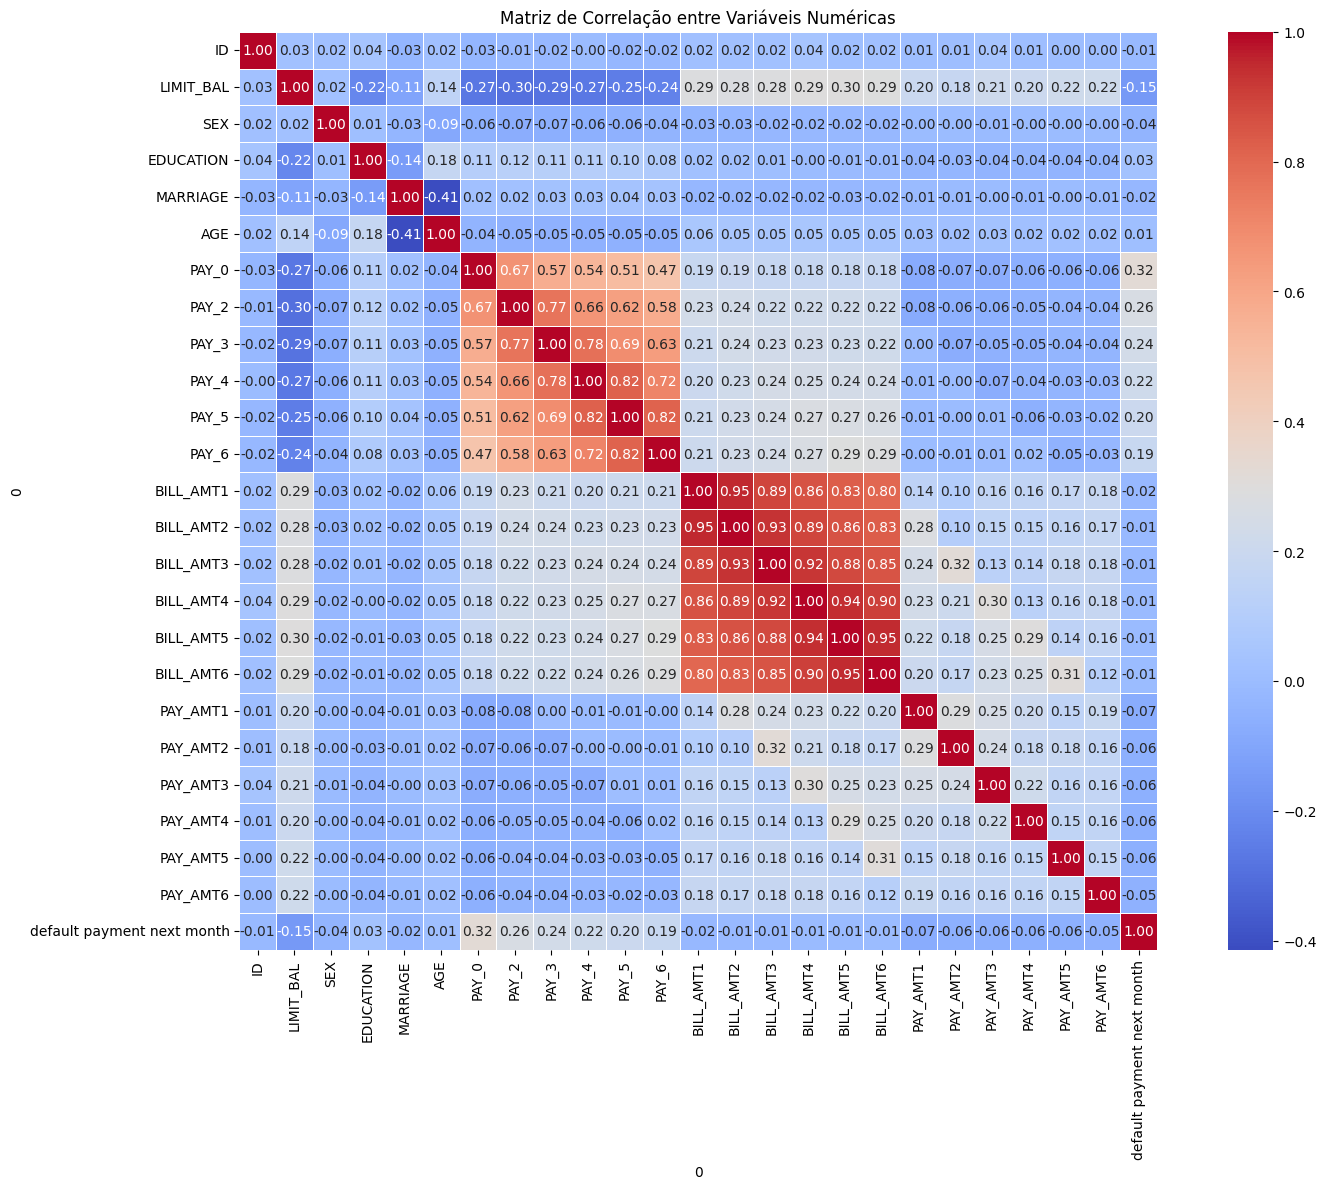

In [14]:
# Calculando a matriz de correlação
matriz_correlacao = df.corr()

# Plotando o mapa de calor
plt.figure(figsize=(16, 12))
sns.heatmap(matriz_correlacao, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()


Identificação de Pares com Alta Correlação

In [15]:
# Calculando a matriz de correlação
correlacoes = df.corr()

# Encontrando pares com correlação > 0.8 ou < -0.8 (ignorando correlação perfeita de 1.0)
limite = 0.8
pares_correlacionados = []

for i in range(len(correlacoes.columns)):
    for j in range(i+1, len(correlacoes.columns)):
        corr = correlacoes.iloc[i, j]
        if abs(corr) > limite:
            pares_correlacionados.append((correlacoes.index[i], correlacoes.columns[j], corr))

# Exibindo os pares encontrados
for var1, var2, corr in pares_correlacionados:
    print(f"{var1} x {var2}: correlação = {corr:.2f}")


PAY_4 x PAY_5: correlação = 0.82
PAY_5 x PAY_6: correlação = 0.82
BILL_AMT1 x BILL_AMT2: correlação = 0.95
BILL_AMT1 x BILL_AMT3: correlação = 0.89
BILL_AMT1 x BILL_AMT4: correlação = 0.86
BILL_AMT1 x BILL_AMT5: correlação = 0.83
BILL_AMT1 x BILL_AMT6: correlação = 0.80
BILL_AMT2 x BILL_AMT3: correlação = 0.93
BILL_AMT2 x BILL_AMT4: correlação = 0.89
BILL_AMT2 x BILL_AMT5: correlação = 0.86
BILL_AMT2 x BILL_AMT6: correlação = 0.83
BILL_AMT3 x BILL_AMT4: correlação = 0.92
BILL_AMT3 x BILL_AMT5: correlação = 0.88
BILL_AMT3 x BILL_AMT6: correlação = 0.85
BILL_AMT4 x BILL_AMT5: correlação = 0.94
BILL_AMT4 x BILL_AMT6: correlação = 0.90
BILL_AMT5 x BILL_AMT6: correlação = 0.95


Gráficos de Dispersão de Pares Altamente Correlacionados

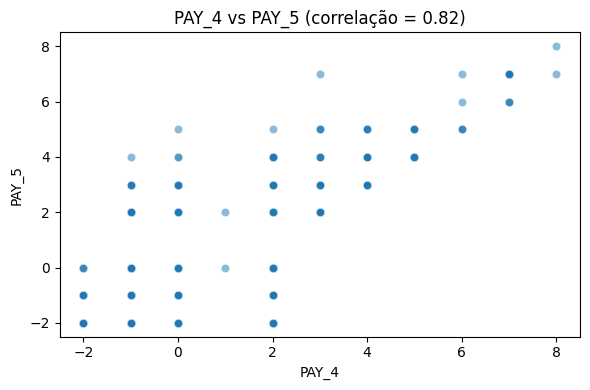

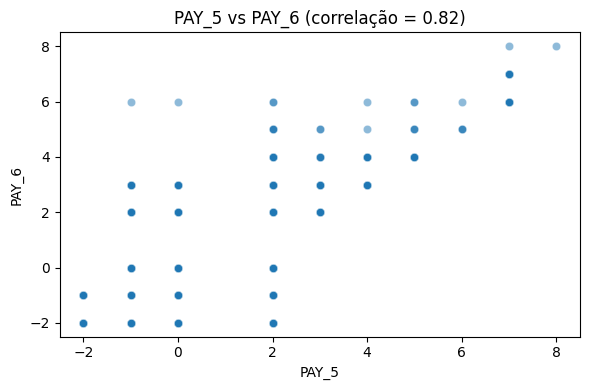

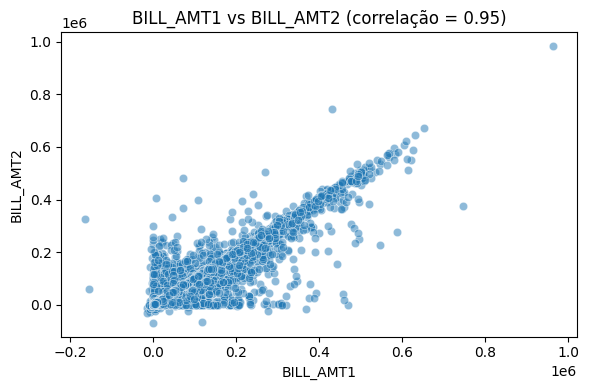

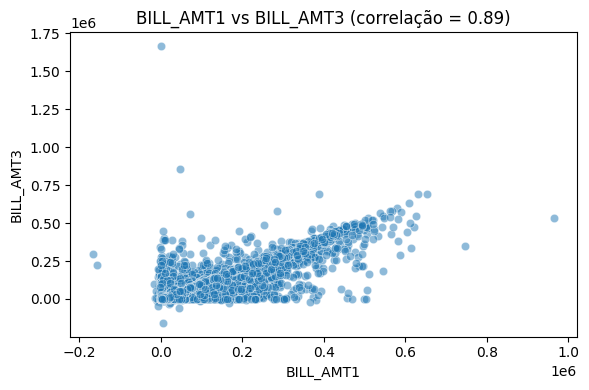

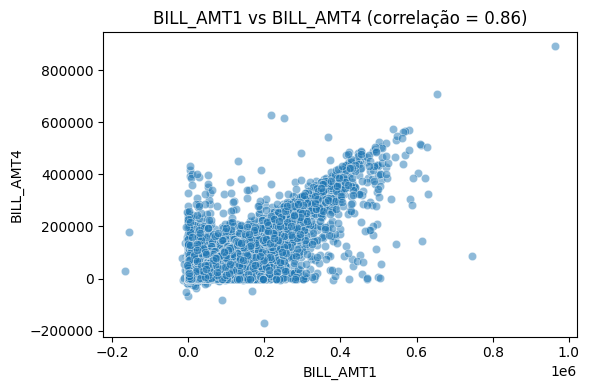

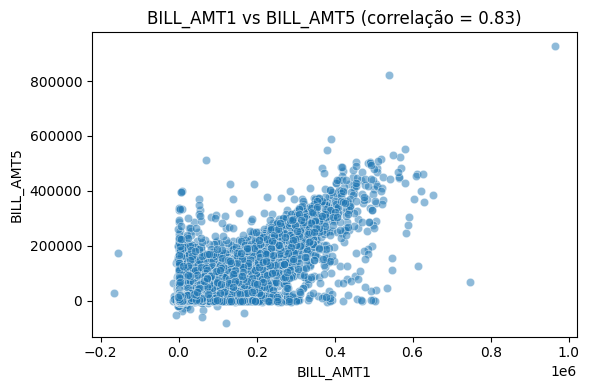

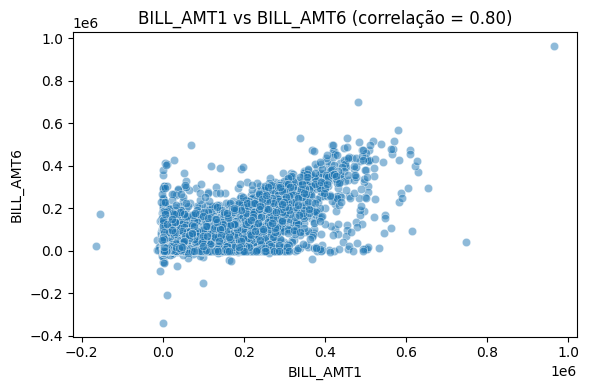

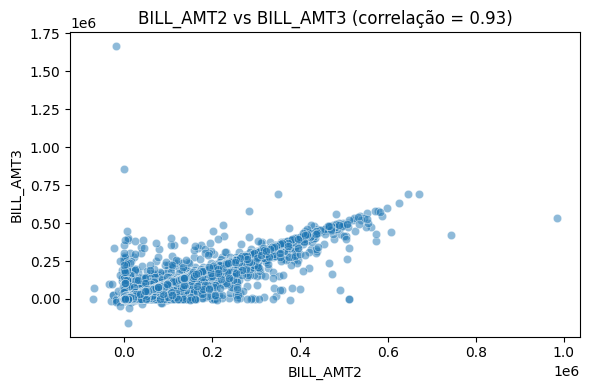

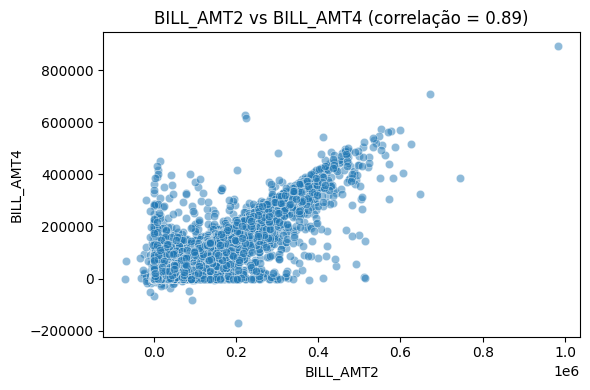

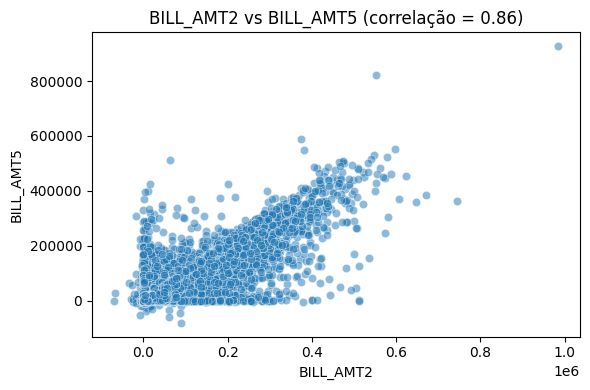

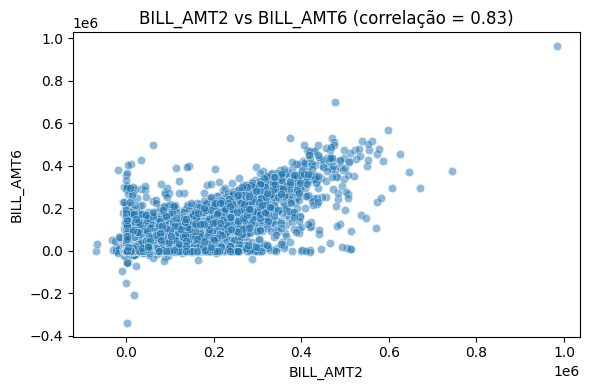

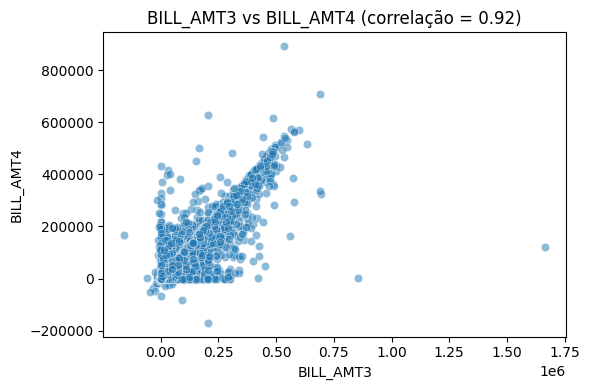

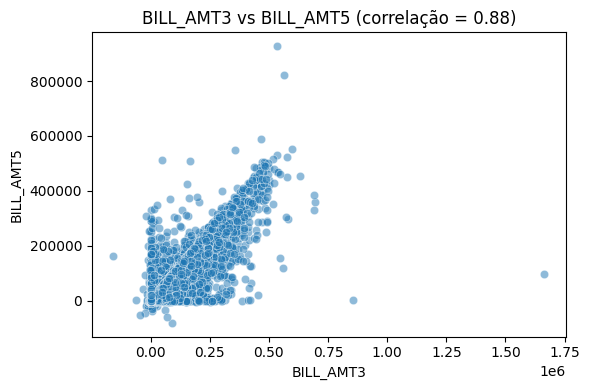

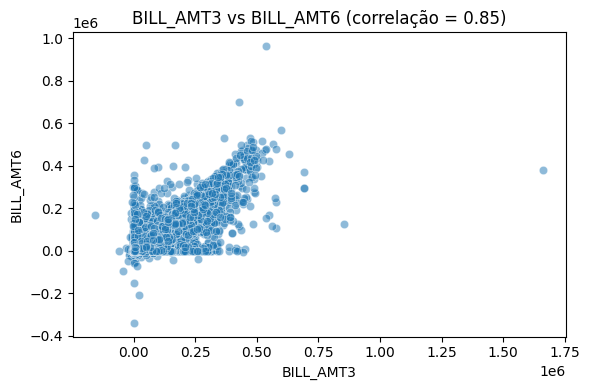

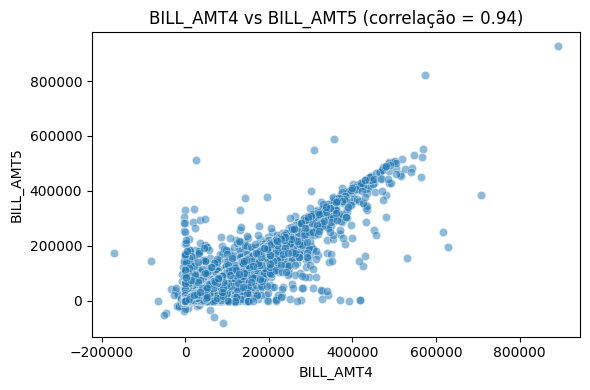

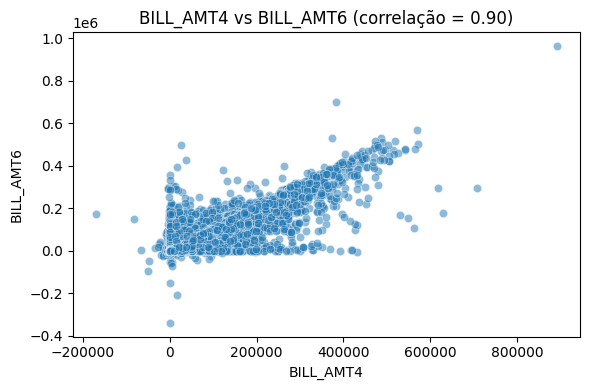

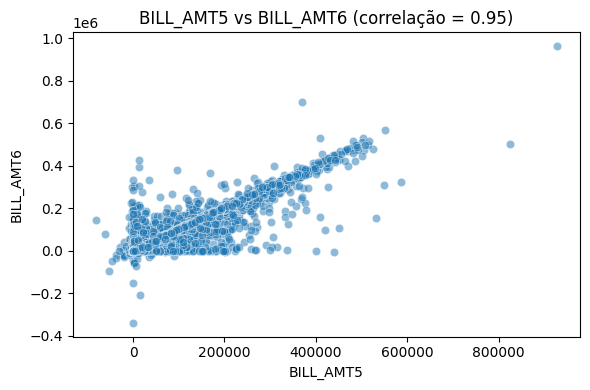

In [16]:
# Plotando os scatter plots dos pares com alta correlação

for var1, var2, corr in pares_correlacionados:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=var1, y=var2, alpha=0.5)
    plt.title(f'{var1} vs {var2} (correlação = {corr:.2f})')
    plt.tight_layout()
    plt.show()

Detecção de outliers

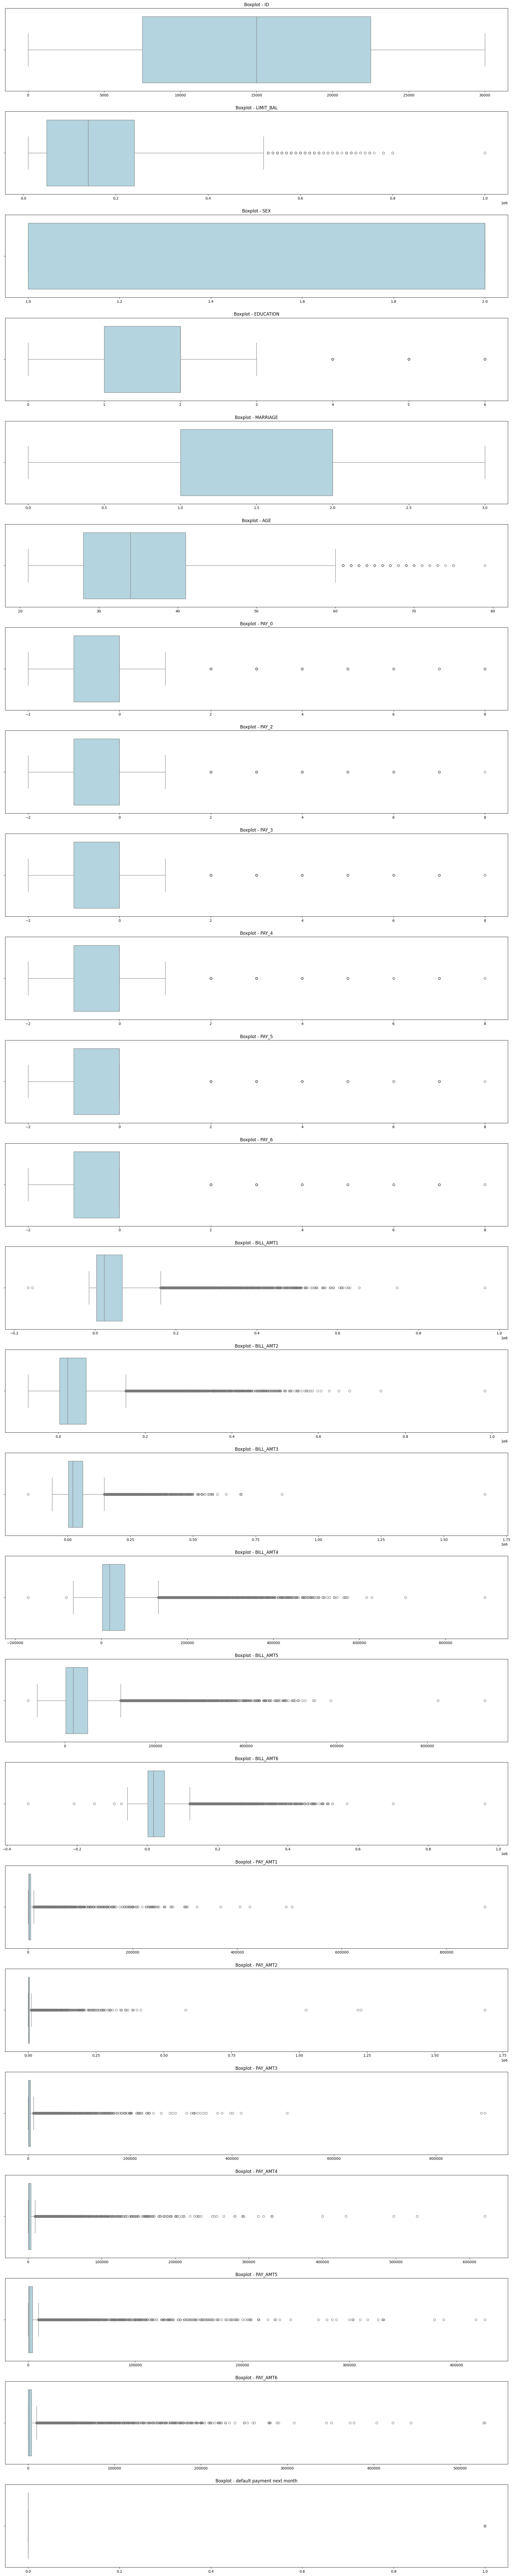

In [17]:
# Boxplots para variáveis numéricas
colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, len(colunas_numericas) * 4))

for i, coluna in enumerate(colunas_numericas):
    plt.subplot(len(colunas_numericas), 1, i + 1)
    sns.boxplot(x=df[coluna], color='lightblue')
    plt.title(f'Boxplot - {coluna}', fontsize=12)
    plt.xlabel('')
    plt.tight_layout()

plt.show()


Detecção Numérica de Outliers - Método do IQR

In [18]:
# Detectando outliers com base no IQR para cada variável numérica
outliers_info = {}

for coluna in colunas_numericas:
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
    outliers_info[coluna] = len(outliers)

# Exibir número de outliers por variável
for coluna, qtde in outliers_info.items():
    print(f'{coluna}: {qtde} outliers')


ID: 0 outliers
LIMIT_BAL: 167 outliers
SEX: 0 outliers
EDUCATION: 454 outliers
MARRIAGE: 0 outliers
AGE: 272 outliers
PAY_0: 3130 outliers
PAY_2: 4410 outliers
PAY_3: 4209 outliers
PAY_4: 3508 outliers
PAY_5: 2968 outliers
PAY_6: 3079 outliers
BILL_AMT1: 2400 outliers
BILL_AMT2: 2395 outliers
BILL_AMT3: 2469 outliers
BILL_AMT4: 2622 outliers
BILL_AMT5: 2725 outliers
BILL_AMT6: 2693 outliers
PAY_AMT1: 2745 outliers
PAY_AMT2: 2714 outliers
PAY_AMT3: 2598 outliers
PAY_AMT4: 2994 outliers
PAY_AMT5: 2945 outliers
PAY_AMT6: 2958 outliers
default payment next month: 6636 outliers


Sinalização de Outliers com Flags

Para cada variável numérica, criamos uma nova coluna indicando se o valor é um outlier (1) ou não (0). Utilizamos o método do IQR (Intervalo Interquartil) para essa detecção.

Essa abordagem permite que modelos como Random Forest e Redes Neurais aprendam com os outliers sem excluí-los ou alterá-los.

In [19]:
# Copia do dataframe original para manter o df intacto
df_outliers = df.copy()

# Selecionar colunas numéricas
colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

# Criar colunas de flag de outlier com base no IQR
for coluna in colunas_numericas:
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    nome_flag = f'{coluna}_outlier'
    df_outliers[nome_flag] = ((df[coluna] < limite_inferior) | (df[coluna] > limite_superior)).astype(int)


Visualização da Quantidade de Outliers

C:\Users\pmarazo\AppData\Local\Temp\ipykernel_10944\291812806.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outlier_counts.values, y=outlier_counts.index, palette='Reds_r')


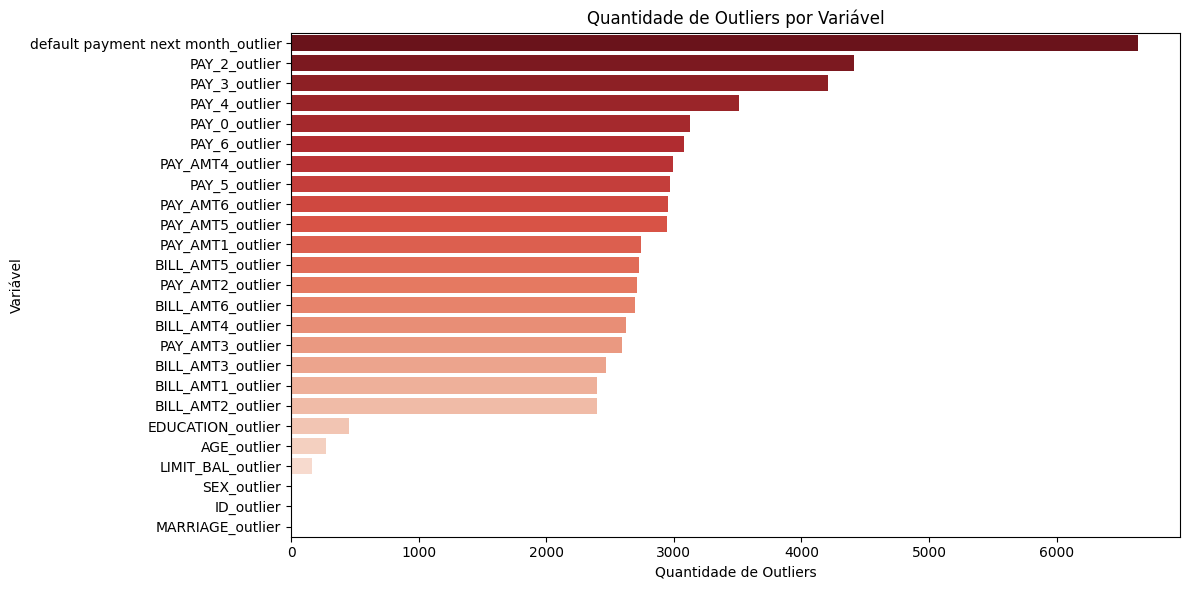

In [20]:
# Selecionar apenas colunas com flags de outlier
colunas_outlier = [col for col in df_outliers.columns if col.endswith('_outlier')]

# Contar o número de outliers por variável
outlier_counts = df_outliers[colunas_outlier].sum().sort_values(ascending=False)

# Plotar gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=outlier_counts.values, y=outlier_counts.index, palette='Reds_r')
plt.title('Quantidade de Outliers por Variável')
plt.xlabel('Quantidade de Outliers')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


# 2. Limpeza e preparação de dados

Verificação de Valores Ausentes

In [21]:
# Verificando valores ausentes
valores_nulos = df.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)

# Exibir apenas colunas com valores ausentes
if not valores_nulos.empty:
    display(valores_nulos)
else:
    print("Nenhum valor ausente encontrado no DataFrame.")

Nenhum valor ausente encontrado no DataFrame.


Codificação de Variáveis Categóricas

In [22]:
# Lista de colunas categóricas codificadas como inteiros
colunas_categoricas_codificadas = ['SEX', 'EDUCATION', 'MARRIAGE']

# Convertendo para o tipo 'category'
for coluna in colunas_categoricas_codificadas:
    df[coluna] = df[coluna].astype('category')

# Verificando tipos após a conversão
print(df[colunas_categoricas_codificadas].dtypes)


0
SEX          category
EDUCATION    category
MARRIAGE     category
dtype: object


Normalização das Variáveis Numéricas

In [23]:
from sklearn.preprocessing import StandardScaler

# Selecionando apenas colunas numéricas (excluindo a variável alvo)
colunas_para_normalizar = df.select_dtypes(include=['float64', 'int64']).drop(columns=['default payment next month']).columns

# Aplicando a normalização
scaler = StandardScaler()
df[colunas_para_normalizar] = scaler.fit_transform(df[colunas_para_normalizar])

# Visualizando resultado parcial
df[colunas_para_normalizar].head()


,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.731993,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,...,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-1.731878,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,...,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-1.731762,-0.597202,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,...,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-1.731647,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,...,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-1.731531,-0.905498,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,...,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187


Remoção da Coluna 'ID'

In [24]:
if 'ID' in df.columns:
    df.drop(columns=['ID'], inplace=True)

df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object', name=0)

# 3. Seleção e/ou engenharia de características 

In [25]:
# Verificando a correlação de todas as variáveis com a variável alvo
correlacoes = df.corr(numeric_only=True)['default payment next month'].sort_values(ascending=False)

# Exibindo as variáveis mais correlacionadas
print(correlacoes)


0
default payment next month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
AGE                           0.013890
BILL_AMT6                    -0.005372
BILL_AMT5                    -0.006760
BILL_AMT4                    -0.010156
BILL_AMT3                    -0.014076
BILL_AMT2                    -0.014193
BILL_AMT1                    -0.019644
PAY_AMT6                     -0.053183
PAY_AMT5                     -0.055124
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT2                     -0.058579
PAY_AMT1                     -0.072929
LIMIT_BAL                    -0.153520
Name: default payment next month, dtype: float64


Criando novas features derivadas

In [26]:
df['mean_delay'] = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)
df['total_bill'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)
df['total_payment'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)
df['payment_ratio'] = df['total_payment'] / df['total_bill'].replace(0, 1)  # evitando divisão por zero
df['payment_gap'] = df['total_bill'] - df['total_payment']

Visualização gráfica das features geradas

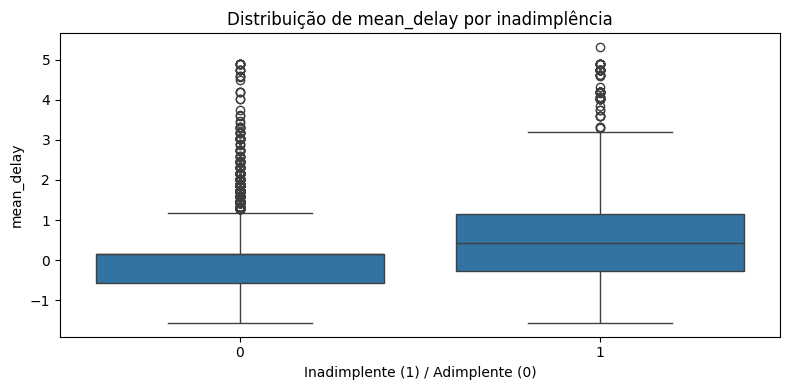

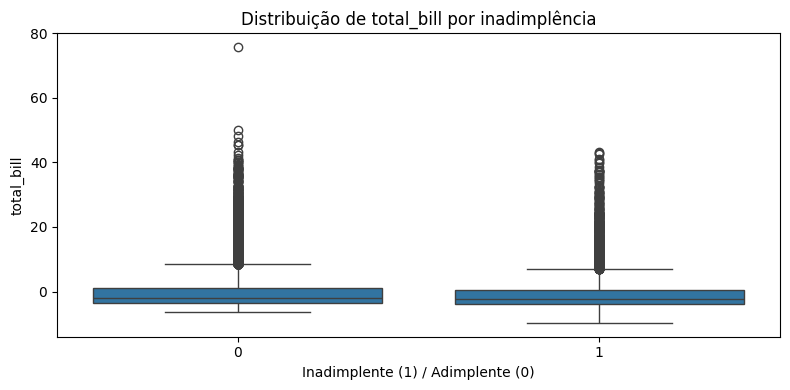

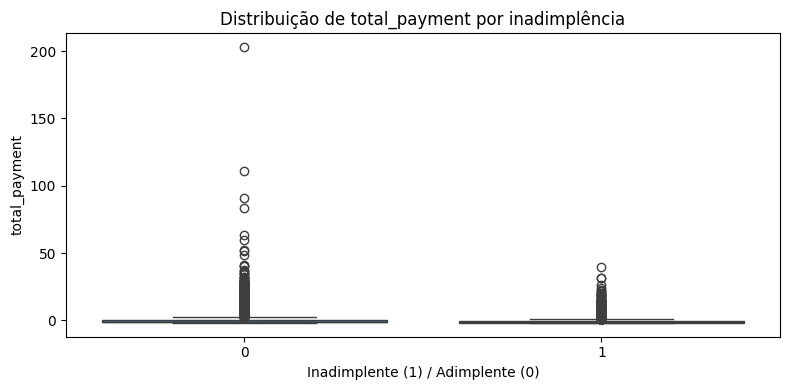

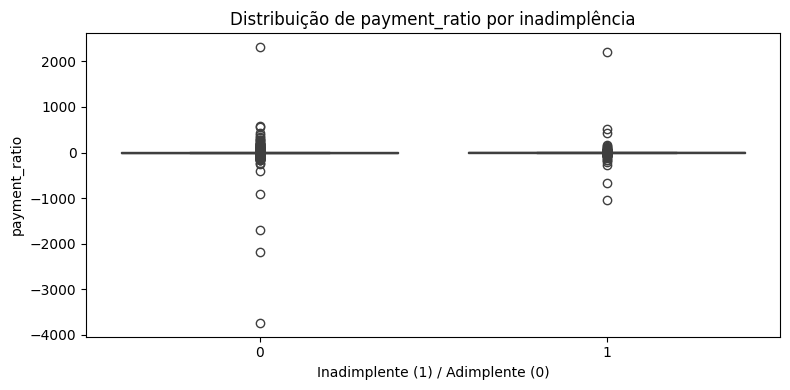

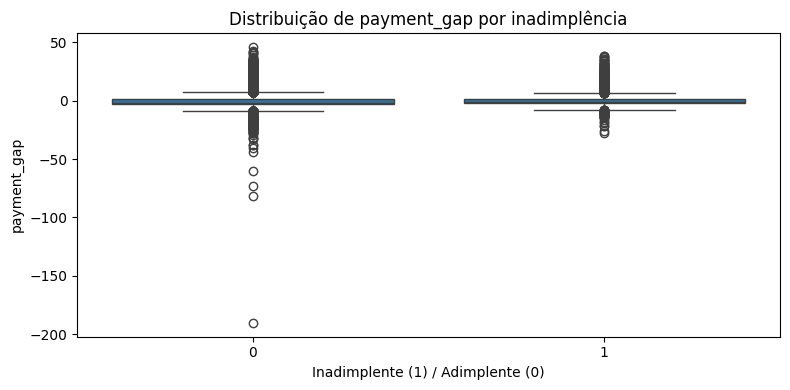

In [27]:
novas_features = ['mean_delay', 'total_bill', 'total_payment', 'payment_ratio', 'payment_gap']

for col in novas_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='default payment next month', y=col, data=df)
    plt.title(f'Distribuição de {col} por inadimplência')
    plt.xlabel('Inadimplente (1) / Adimplente (0)')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


Criação de Novas Features: Média de Atraso e Gap de Pagamento


In [28]:
# Criando a média de atraso
colunas_pagamento = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df['mean_delay'] = df[colunas_pagamento].mean(axis=1)

# Criando o gap de pagamento
colunas_fatura = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
colunas_pagamento_valor = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

df['total_bill'] = df[colunas_fatura].sum(axis=1)
df['total_payment'] = df[colunas_pagamento_valor].sum(axis=1)
df['payment_gap'] = df['total_bill'] - df['total_payment']

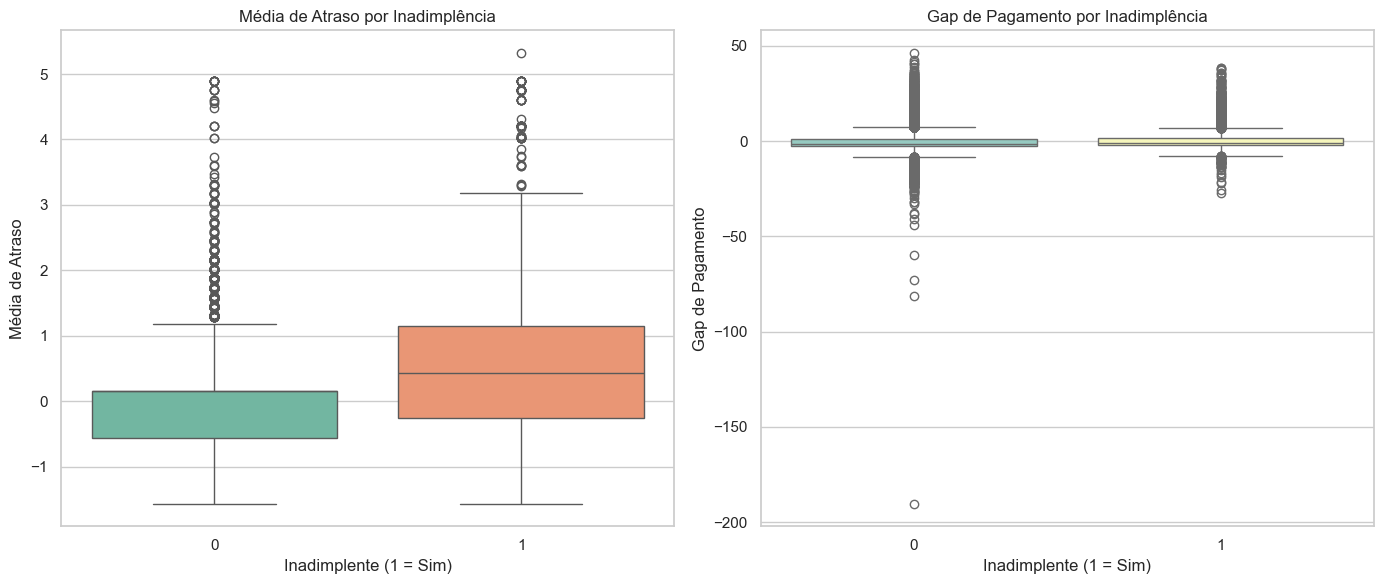

In [29]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

# Boxplot da média de atraso
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='default payment next month', y='mean_delay', hue='default payment next month', palette='Set2', legend=False)
plt.title('Média de Atraso por Inadimplência')
plt.xlabel('Inadimplente (1 = Sim)')
plt.ylabel('Média de Atraso')

# Boxplot do gap de pagamento
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='default payment next month', y='payment_gap', hue='default payment next month', palette='Set3', legend=False)
plt.title('Gap de Pagamento por Inadimplência')
plt.xlabel('Inadimplente (1 = Sim)')
plt.ylabel('Gap de Pagamento')

plt.tight_layout()
plt.show()


# 4. Balanceamento de classes

Verificando o balanceamento da variável alvo

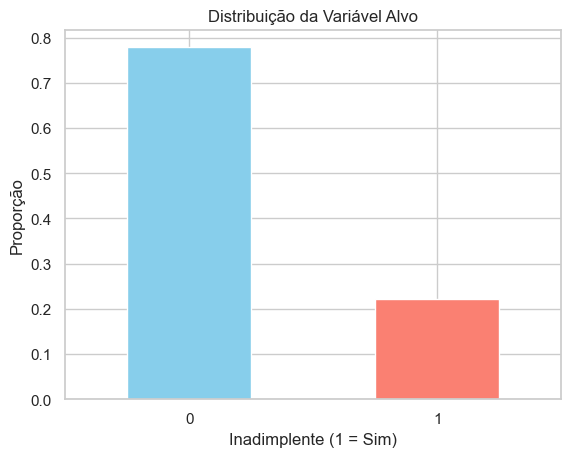

In [30]:
df['default payment next month'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição da Variável Alvo')
plt.xlabel('Inadimplente (1 = Sim)')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.show()

Balanceamento das Classes com SMOTE

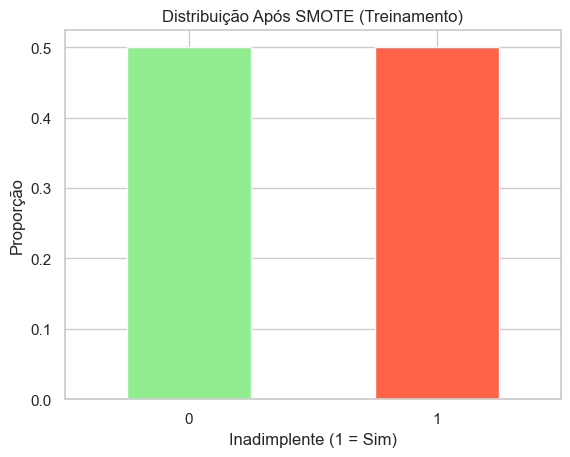

In [31]:
# Separando variáveis preditoras e alvo
X = df.drop(columns=['default payment next month'])
y = df['default payment next month']

# Dividindo em treino e teste antes do balanceamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicando SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verificando o balanceamento após SMOTE
y_train_res.value_counts(normalize=True).plot(kind='bar', color=['lightgreen', 'tomato'])
plt.title('Distribuição Após SMOTE (Treinamento)')
plt.xlabel('Inadimplente (1 = Sim)')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.show()


# 5. Construção de modelos

Construção do Modelo: Random Forest


Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      7009
           1       0.58      0.42      0.49      1991

    accuracy                           0.81      9000
   macro avg       0.72      0.67      0.68      9000
weighted avg       0.79      0.81      0.79      9000



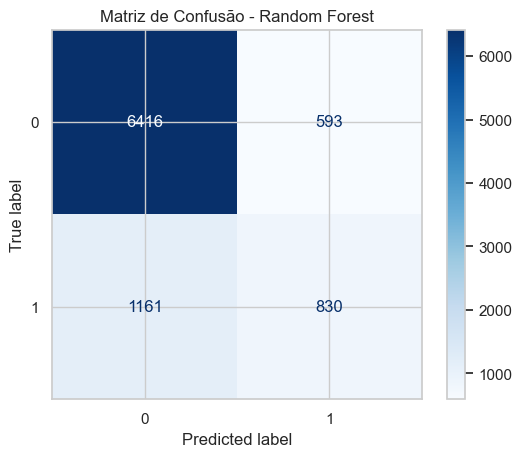

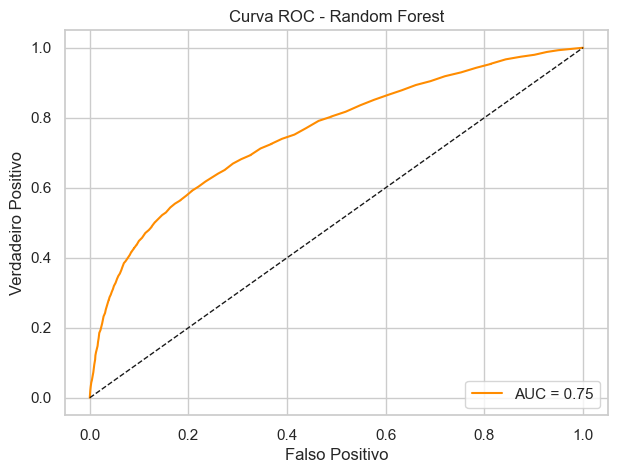

C:\Users\pmarazo\AppData\Local\Temp\ipykernel_10944\191044922.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:10], y=features[indices][:10], palette="viridis")


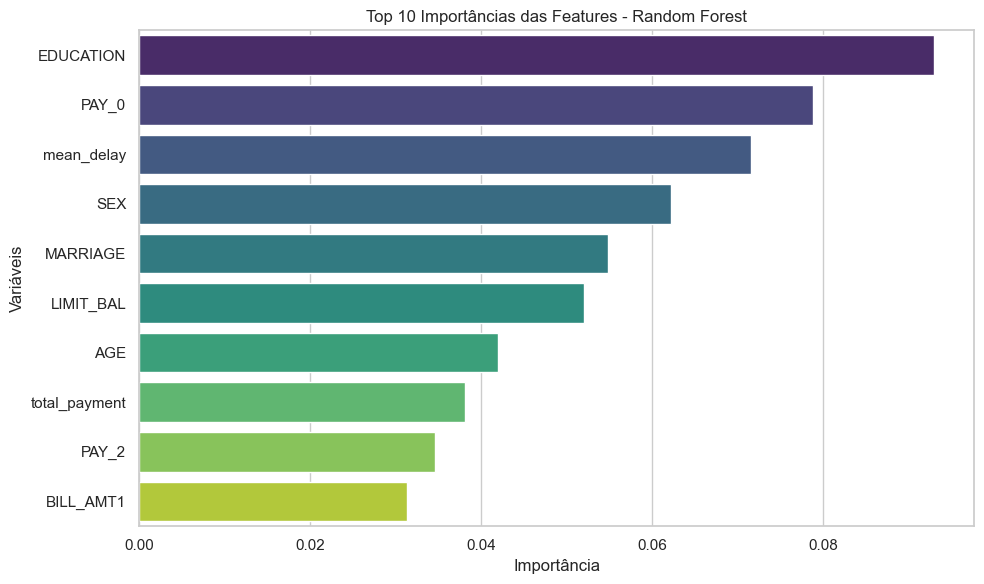

In [32]:
# 1. Separando variáveis preditoras (X) e alvo (y)
X = df.drop(columns=['default payment next month'])
y = df['default payment next month']

# 2. Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 3. Aplicando SMOTE nos dados de treino
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 4. Treinamento do modelo
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sm, y_train_sm)

# 5. Previsões e avaliação
y_pred = rf.predict(X_test)

print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))

# 6. Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

# 7. Curva ROC
y_proba = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 8. Importância das features
importances = rf.feature_importances_
indices = importances.argsort()[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:10], y=features[indices][:10], palette="viridis")
plt.title('Top 10 Importâncias das Features - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()


Construção do Modelo: Rede Neural Artificial

c:\Users\pmarazo\Documents\GitHub\aprendizado-supervisionado\venv_tensorflow\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7564 - loss: 0.5519 - val_accuracy: 0.8060 - val_loss: 0.4691
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8111 - loss: 0.4676 - val_accuracy: 0.8092 - val_loss: 0.4611
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8092 - loss: 0.4579 - val_accuracy: 0.8094 - val_loss: 0.4614
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8162 - loss: 0.4479 - val_accuracy: 0.8112 - val_loss: 0.4530
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8144 - loss: 0.4528 - val_accuracy: 0.8092 - val_loss: 0.4570
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8145 - loss: 0.4462 - val_accuracy: 0.8106 - val_loss: 0.4522
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8198 - loss: 0.4376 - val_accuracy: 0.8115 - val_loss: 0.4498
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8151 - loss: 0.4414 - val_accuracy: 0.

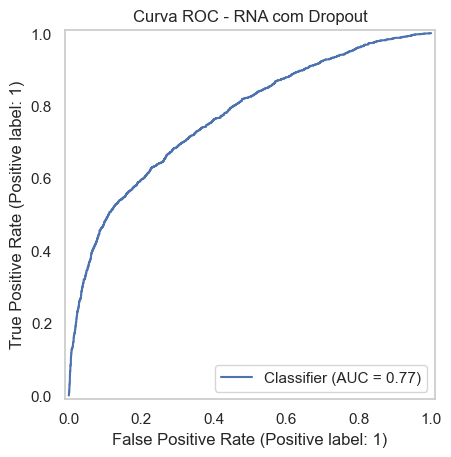

In [33]:
# Features e target
X = df.drop(columns='default payment next month')
y = df['default payment next month']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalização (se necessário, dependendo das variáveis numéricas)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construção da rede neural com Dropout
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Dropout para reduzir overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Saída binária

# Compilação
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Avaliação
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Previsões
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Curva ROC
y_proba = model.predict(X_test_scaled).ravel()
roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC ROC: {roc_auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('Curva ROC - RNA com Dropout')
plt.grid()
plt.show()


Comparação RF vs RNA

In [ ]:
# 1. Treinando Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# 2. Treinando Rede Neural Artificial (RNA)
rna = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
rna.compile(optimizer='adam', loss='mse')
rna.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
rna_pred = rna.predict(X_test).flatten()

# 3. Métricas
def avaliar_modelo(nome, y_test, y_pred):
    return {
        "Modelo": nome,
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }

resultados = [
    avaliar_modelo("Random Forest", y_test, rf_pred),
    avaliar_modelo("RNA", y_test, rna_pred)
]

df_resultados = pd.DataFrame(resultados)
print(df_resultados)


c:\Users\pmarazo\Documents\GitHub\aprendizado-supervisionado\venv_tensorflow\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
          Modelo       MSE       MAE        R²
0  Random Forest  0.142261  0.276135  0.174113
1            RNA  0.160286  0.272460  0.069467


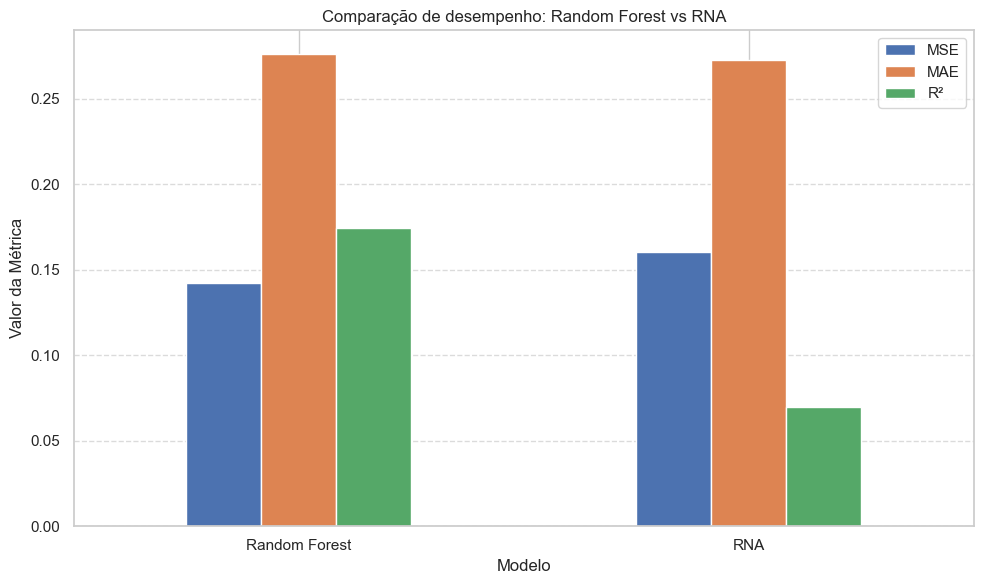

In [35]:
# Gráfico de barras para comparar
df_resultados.set_index("Modelo")[["MSE", "MAE", "R²"]].plot(kind='bar', figsize=(10,6))
plt.title("Comparação de desempenho: Random Forest vs RNA")
plt.ylabel("Valor da Métrica")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()